# Regression and Plotting Trends
This notebook aims to find any connections between ZIP Codes where breweries are successful (where there are many breweries) and the information provided from the tax data.

### Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

### Read in the data

In [2]:
tax_all_df= pd.read_csv("resources/Tax_DF_All_Columns_For_Merge.csv")

brewery_df= pd.read_csv("resources/Brewers_Association_Data.csv")

In [3]:
tax_all_df.head()

,Unnamed: 0,STATE FIPS,STATE,ZIPCODE,Unnamed: 4,NUMBER OF RETURNS,MARITAL STATUS (SINGLE),MARITAL STATUS (JOINT),MARITAL STATUS (HEAD OF HOUSEHOLD),RETURNS WITH SIGNATURE,...,NUMBER OF RETURNS WITH TOTAL TAX CREDITS,TOTAL TAX CREDITS AMOUNT,NUMBER OF RETURNS WITH FOREIGN TAX CREDIT,FOREIGN TAX CREDIT AMOUNT,NUMBER OF RETURNS WITH CHILD AND DEPENDENT CARE CREDIT,CHILD AND DEPENDENT CARE CREDIT AMOUNT,NUMBER OF RETURNS WITH SELF-EMPLOYMENT TAX,SELF-EMPLOYMENT TAX AMOUNT,NUMBER OF RETURNS WITH INCOME TAX,INCOME TAX AMOUNT
0,1,1,AL,35004,0,5210,2150,2140,830,2470,...,1840,2377,80,7,410,245,530,1190,3870,27082
1,2,1,AL,35005,0,3100,1340,890,830,1740,...,1000,1066,0,0,180,102,250,368,1970,8580
2,3,1,AL,35006,0,1200,430,600,170,790,...,360,441,0,0,0,0,100,172,860,4712
3,4,1,AL,35007,0,11940,4770,5140,1750,5450,...,4070,5256,250,13,850,481,1710,4161,8440,70623
4,5,1,AL,35010,0,7910,2910,2730,2120,4090,...,2470,2949,200,191,490,253,860,2088,4680,38102


In [4]:
brewery_df.head()

,Unnamed: 0,Brewery,Address,City,State,ZIP Code
0,0,5 Rivers Brewing LLC,NaN,Spanish Fort,AL,36527.0
1,1,Avondale Brewing Co,201 41st St S,Birmingham,AL,35222.0
2,2,Back Forty Beer Co,200 N 6th St,Gadsden,AL,35901.0
3,3,Back Forty Beer Company - Birmingham,3201 1st Avenue N,Birmingham,AL,35222.0
4,4,Below the Radar Brewing Co,220 Holmes Ave NE,Huntsville,AL,35801.0


### Clean data for merge

In [5]:
def trim_fraction(text):
    if ".0" in text:
        return text[:text.rfind(".0")]
    return text

brewery_df["Address"] = brewery_df["Address"].astype("str")
brewery_df["Brewery"] = brewery_df["Brewery"].astype("str")
brewery_df["ZIP Code"] = brewery_df["ZIP Code"].astype("str")

brewery_df["Brewery"] = brewery_df["Brewery"].str.lower()
brewery_df["Address"] = brewery_df["Address"].str.lower()

no_double_address_df = brewery_df.drop_duplicates(["Address"])
no_double_address_or_brewery_df = no_double_address_df.drop_duplicates(["Brewery"])

In [6]:
no_double_address_or_brewery_df["ZIP Code"] = no_double_address_or_brewery_df["ZIP Code"].apply(trim_fraction)

C:\Users\Overlord\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
brewery_df= no_double_address_or_brewery_df

In [8]:
brewery_df.head()

,Unnamed: 0,Brewery,Address,City,State,ZIP Code
0,0,5 rivers brewing llc,nan,Spanish Fort,AL,36527
1,1,avondale brewing co,201 41st st s,Birmingham,AL,35222
2,2,back forty beer co,200 n 6th st,Gadsden,AL,35901
3,3,back forty beer company - birmingham,3201 1st avenue n,Birmingham,AL,35222
4,4,below the radar brewing co,220 holmes ave ne,Huntsville,AL,35801


In [9]:
tax_all_df = tax_all_df.rename(columns = {
    "ZIPCODE": "ZIP Code"
})

tax_all_df["ZIP Code"] = tax_all_df["ZIP Code"].astype("str")

### Merge data

In [10]:
full_merge_df = pd.merge(
    tax_all_df, 
    brewery_df, 
    how = "outer",
    on= "ZIP Code"
)

In [11]:
brewery_zips_df= full_merge_df
brewery_zips_df['Brewery Count'] = full_merge_df['ZIP Code'].groupby(full_merge_df['ZIP Code']).transform('count')
brewery_zips_plural_df= brewery_zips_df.loc[brewery_zips_df['Brewery Count'] > 1]
brewery_zips_plural_no_dups_df= brewery_zips_plural_df.drop_duplicates("ZIP Code")

### Define columns with quantitative information
These will be plotted against the number of breweries in a ZIP Code

In [12]:
quant_columns= ['NUMBER OF RETURNS',
       'MARITAL STATUS (SINGLE)', 'MARITAL STATUS (JOINT)',
       'MARITAL STATUS (HEAD OF HOUSEHOLD)', 'RETURNS WITH SIGNATURE',
       'NUMBER OF EXEMPTIONS', 'NUMBER OF DEPENDENTS', 'ELDERLY',
       'NUMBER OF RETURNS WITH TOTAL INCOME', 'TOTAL INCOME AMOUNT',
       'NUMBER OF RETURNS WITH SALARIES AND WAGES',
       'SALARIES AND WAGES AMOUNT', 'NUMBER OF FARM RETURNS',
       'NUMBER OF RETURNS WITH UNEMPLOYMENT COMPENSATION',
       'UNEMPLOYMENT COMPENSATION AMOUNT',
       'NUMBER OF RETURNS WITH SOCIAL SECURITY BENEFITS',
       'TAXABLE SOCIAL SECURITY BENEFITS AMOUNT',
       'NUMBER OF RETURNS WITH EDUCATION EXPENSES',
       'EDUCATION EXPENSES AMOUNT',
       'NUMBER OF RETURNS WITH STUDENT LOAN DEDUCTIONS',
       'STUDENT LOAN DEDUCTIONS AMOUNT',
       'NUMBER OF RETURNS WITH TUITION AND FEEDS DEDUCTIONS',
       'TUITION AND FEEDS DEDUCTIONS AMOUNT',
       'NUMBER OF RETURNS WITH DOMESTIC PRODUCTION ACTIVITIES DEDUCTIONS',
       'DOMESTIC PRODUCTION ACTIVITES DEDUCTIONS AMOUNT',
       'NUMBER OF RETURNS WITH REAL ESTATE TAXES', 'REAL ESTATE TAXES AMOUNT',
       'NUMBER OF RETURNS WITH PERSONAL PROPERTY TAXES',
       'PERSONAL PROPERTY TAXES AMOUNT',
       'NUMBER OF RETURNS WITH TOTAL CHARITABLE CONTRIBUTIONS',
       'TOTAL CHARITABLE CONTRIBUTIONS AMOUNT',
       'NUMBER OF RETURNS WITH TAXABLE INCOME', 'TAXABLE INCOME AMOUNT',
       'NUMBER OF RETURNS WITH INCOME TAX BEFORE CREDITS',
       'INCOME TAX BEFORE CREDITS AMOUNT',
       'NUMBER OF RETURNS WITH TOTAL TAX CREDITS', 'TOTAL TAX CREDITS AMOUNT',
       'NUMBER OF RETURNS WITH FOREIGN TAX CREDIT',
       'FOREIGN TAX CREDIT AMOUNT',
       'NUMBER OF RETURNS WITH CHILD AND DEPENDENT CARE CREDIT',
       'CHILD AND DEPENDENT CARE CREDIT AMOUNT',
       'NUMBER OF RETURNS WITH SELF-EMPLOYMENT TAX',
       'SELF-EMPLOYMENT TAX AMOUNT', 'NUMBER OF RETURNS WITH INCOME TAX',
       'INCOME TAX AMOUNT']

### Regression and Plotting

C:\Users\Overlord\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\Overlord\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

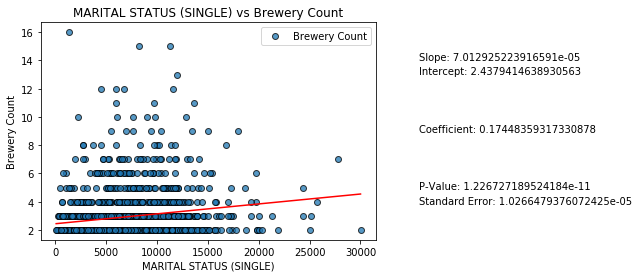

<Figure size 432x288 with 0 Axes>

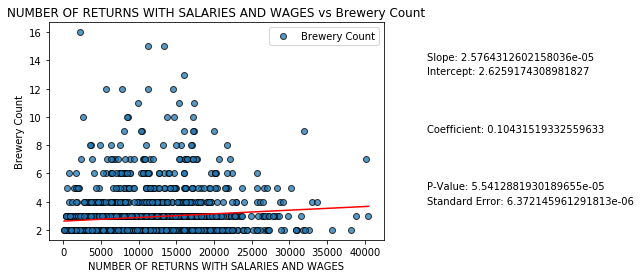

<Figure size 432x288 with 0 Axes>

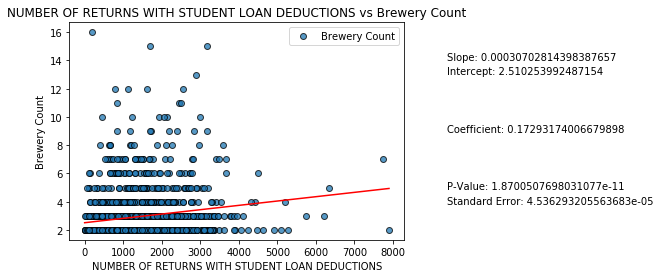

<Figure size 432x288 with 0 Axes>

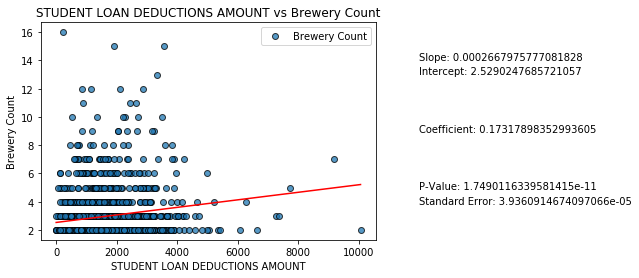

<Figure size 432x288 with 0 Axes>

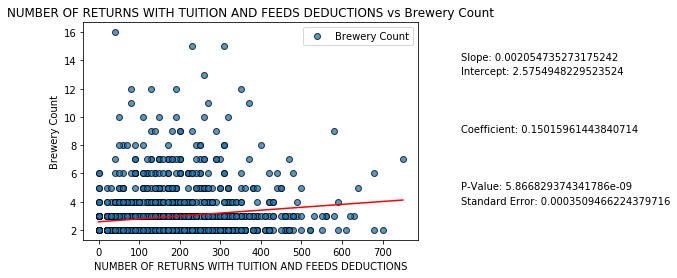

<Figure size 432x288 with 0 Axes>

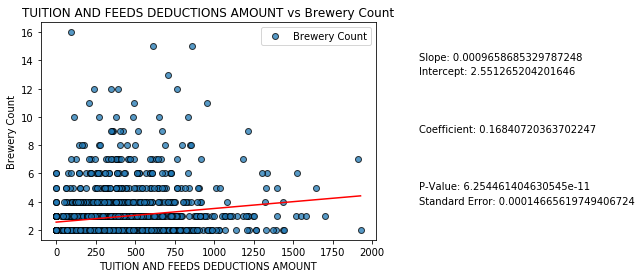

<Figure size 432x288 with 0 Axes>

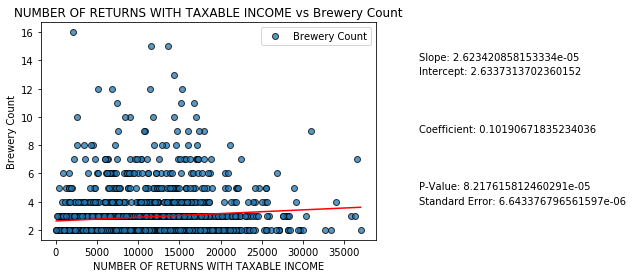

<Figure size 432x288 with 0 Axes>

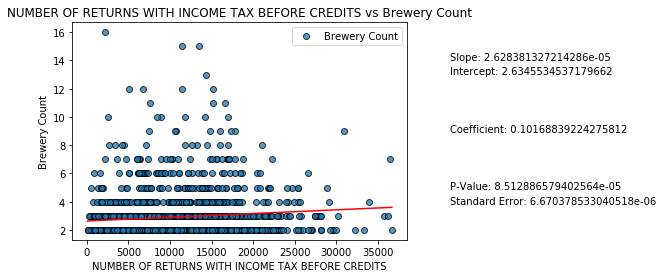

<Figure size 432x288 with 0 Axes>

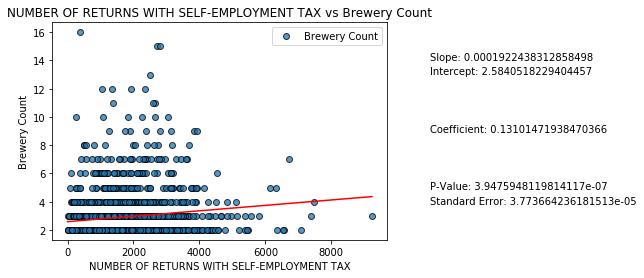

<Figure size 432x288 with 0 Axes>

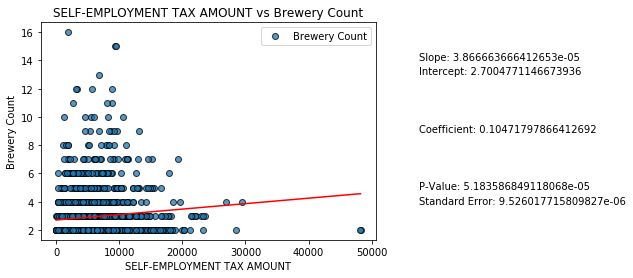

<Figure size 432x288 with 0 Axes>

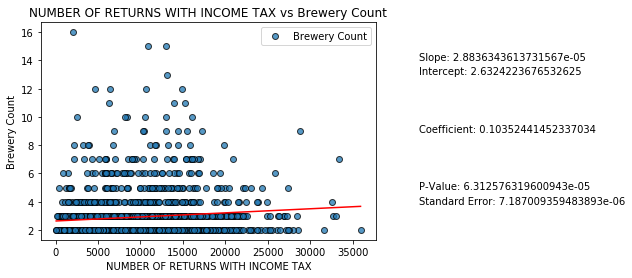

In [13]:
y= "Brewery Count"

for x in quant_columns:
    
    mask= ~np.isnan(brewery_zips_plural_no_dups_df[x]) & ~np.isnan(brewery_zips_plural_no_dups_df[y])
    m,b,r,p,st_err= linregress(brewery_zips_plural_no_dups_df[x][mask],brewery_zips_plural_no_dups_df[y][mask])

    x_min= brewery_zips_plural_no_dups_df[x].min()
    x_max= brewery_zips_plural_no_dups_df[x].max()
    

    if abs(r) > .1 and abs(r) != 1:
        fig= plt.figure()
        
        ax= brewery_zips_plural_no_dups_df.plot(
            x,
            y, 
            marker= "o", 
            linewidth= 0,
            alpha= .75,
            markeredgecolor= 'k'
        )
        
        ax.plot([x_min,x_max], [m*x_min+b,m*x_max+b], 'r')

        plt.title(x+" vs "+y)
        plt.xlabel(x)
        plt.ylabel(y)
        
        ax.text(1,.75,"Slope: "+str(m), transform=plt.gcf().transFigure)
        ax.text(1,.7,"Intercept: "+str(b), transform=plt.gcf().transFigure)
        ax.text(1,.5,"Coefficient: "+str(r), transform=plt.gcf().transFigure)
        ax.text(1,.3,"P-Value: "+str(p), transform=plt.gcf().transFigure)
        ax.text(1,.25,"Standard Error: "+str(st_err), transform=plt.gcf().transFigure)

        plt.gcf().savefig(
            "images/"+
            "_".join(x.split())+
            "_by_"+
            "_".join(y.split())+
            ".png",
            bbox_inches= "tight" 
        )
        
        fig.show()